'''
Lab 9 - Sentiment Classification Example (Reddit Data)

Ref: https://pythonspot.com/python-sentiment-analysis/
'''

In [33]:
# Import packages
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names

import pandas as pd
import numpy as np

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import heapq

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [32]:
# Import scraped data into dataframe 
df = pd.read_csv('merged_clean_scores.csv')

# Remove unwanted content
r_list = df.values.tolist()
for i in r_list:
    i[3]=i[3].rstrip("\r")
    i[4]=i[4].rstrip("\r")
df = pd.DataFrame(r_list, columns = ['subreddit', 'id', 'submission', 'p or c', 'Processed', 'ups',
       'downs', 'num_comments', 'score', 'total_awards_received'])
df.to_csv('sentiment_output.csv', index = False)

# Remove discord 
df['Processed']= df['Processed'].str.replace('discord', '')

df

,subreddit,id,submission,p or c,Processed,ups,downs,num_comments,score,total_awards_received
0,CardanoNFTs,mnko80,mnko80,post,cardano nft marketplace projects updated 2 9 2...,144.0,0.0,260.0,144.0,14.0
1,CardanoNFTs,gtyvi7w,mnko80,comment,im one co founders nft craze also working nft ...,19.0,0.0,NaN,19.0,0.0
2,CardanoNFTs,hb9geeo,mnko80,comment,needs tokhun io list,9.0,0.0,NaN,9.0,1.0
3,CardanoNFTs,gy8awd2,mnko80,comment,hey im founder also working expanding platform...,8.0,0.0,NaN,8.0,0.0
4,CardanoNFTs,gw0807w,mnko80,comment,check running mostly single mint nfts,5.0,0.0,NaN,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...
87470,SolanaNFTs,t3d3ej,t3d3ej,post,free cool cats solana nft everyone worth 30 00...,0.0,0.0,2.0,0.0,0.0
87471,SolanaNFTs,hyrjnqm,t3d3ej,comment,additional details guarantee win make sure fol...,1.0,0.0,NaN,1.0,0.0
87472,SolanaNFTs,se2vdl,se2vdl,post,claim free nifty records nft joining,0.0,0.0,0.0,0.0,0.0
87473,SolanaNFTs,r8n97m,r8n97m,post,3 free nft giveaway upvote drop address,0.0,0.0,2.0,0.0,0.0


In [35]:
#https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

df['POS tagged'] = df['Processed'].apply(token_stop_pos)
df['POS tagged']

0        [(cardano, n), (nft, a), (marketplace, n), (pr...
1        [(im, v), (one, None), (co, n), (founders, n),...
2            [(needs, n), (tokhun, v), (io, a), (list, n)]
3        [(hey, n), (im, n), (founder, n), (also, r), (...
4        [(check, n), (running, v), (mostly, r), (singl...
                               ...                        
87470    [(free, a), (cool, n), (cats, n), (solana, v),...
87471    [(additional, a), (details, n), (guarantee, n)...
87472    [(claim, n), (free, a), (nifty, n), (records, ...
87473    [(3, None), (free, a), (nft, None), (giveaway,...
87474    [(double, r), (ur, a), (chances, n), (join, v)...
Name: POS tagged, Length: 87475, dtype: object

In [36]:
# Lemmatize 

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df['Lemma'] = df['POS tagged'].apply(lemmatize)
df['Lemma']

0          cardano nft marketplace project update 2 9 2...
1          im one co founder nft craze also work nft ma...
2                                      need tokhun io list
3          hey im founder also work expand platform ful...
4                        check run mostly single mint nfts
                               ...                        
87470      free cool cat solana nft everyone worth 30 0...
87471      additional detail guarantee win make sure fo...
87472                     claim free nifty record nft join
87473              3 free nft giveaway upvote drop address
87474      double ur chance join server read tweet pls ...
Name: Lemma, Length: 87475, dtype: object

In [37]:
#Vader

analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df['Vader Sentiment'] = df['Lemma'].apply(vadersentimentanalysis)

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'

df['Vader Analysis'] = df['Vader Sentiment'].apply(vader_analysis)

df['Vader Analysis']

0        Positive
1        Positive
2         Neutral
3         Neutral
4         Neutral
           ...   
87470    Positive
87471    Positive
87472    Positive
87473     Neutral
87474    Positive
Name: Vader Analysis, Length: 87475, dtype: object

In [ ]:
# Display amount for each sentiment
print(df['Vader Analysis'].value_counts())

In [ ]:
#Create test-set

train, test = train_test_split(df, test_size=0.3)

train = pd.DataFrame(train)
test = pd.DataFrame(test)


In [ ]:
# We re-format the data to fit the classifier

def word_feats(words):
    return dict([(word, True) for word in words])

positive_features = [((word_feats(word_tokenize(pos))), 'pos') for pos in train.loc[train['Vader Analysis'] == 'Positive']['Lemma']]
negative_features = [(word_feats(word_tokenize(neg)), 'neg') for neg in train.loc[train['Vader Analysis'] == 'Negative']['Lemma']]
neutral_features = [(word_feats(word_tokenize(neu)), 'neu') for neu in train.loc[train['Vader Analysis'] == 'Neutral']['Lemma']]

train_data = positive_features + negative_features + neutral_features


In [ ]:
# We train the classifier: Naive Bayes

classifier = NaiveBayesClassifier.train(train_data)

In [ ]:
# Predict
sentences = []
positives = []
negatives = []
labels = []
original = []

for sentence in test['Lemma']:
    neg = 0
    pos = 0
    label = ''
    sentence = str(sentence).lower()
    words = sentence.split(' ')
    
    for word in words:
        classResult = classifier.classify(word_feats(word))
        
        if classResult == 'neg':
            neg = neg + 1
        if classResult == 'pos':
            pos = pos + 1
    
    if pos > neg :
        label = 'Positive'
    if neg > pos:
        label = 'Negative'
    if pos < 0.5 or neg < 0.5:
        label = 'Neutral'

    sentences.append(sentence)
    positives.append(float(pos)/len(words))
    negatives.append(float(neg)/len(words))
    labels.append(label)

result = pd.DataFrame({
    'text': sentences,
    'positive': positives,
    'negative': negatives,
    'label' : labels})

result

In [38]:
# Which posts have the most positive/negative comments? - Top 10
dict_ = {}

for id in df['submission'].unique():
    dict_[id] = sum(df.loc[df['submission'] == id].loc[df['p or c'] == 'comment']['Vader Sentiment'])
    

In [40]:
max_pos = heapq.nlargest(10, dict_, key=dict_.get)
max_neg = heapq.nsmallest(10, dict_, key=dict_.get)

print('Positive id:s', max_pos)
print('\nNegative id:s', max_neg)

max_pos_list = []
for i in max_pos:
    max_pos_list.append(df.loc[df['submission'] == i].loc[df['p or c'] == 'post']['Processed'].values[0])
    
max_neg_list = []
for i in max_neg:
    max_neg_list.append(df.loc[df['submission'] == i].loc[df['p or c'] == 'post']['Processed'].values[0])
    
print('\nPositive examples:', max_pos_list)

print('\nNegative examples:', max_neg_list)

Positive id:s ['o6m25h', 't7bmxp', 'tb0mbk', 'tbw2q6', 'nm4lxf', 't8k84d', 'r7r209', 't7q04j', 'q9qkyt', 'pfy6i8']

Negative id:s ['lsvvo9', 'n0lbu8', 'myvs3c', 'n0vsaa', 'qpdwxb', 'py0wut', 'pyrz5m', 'sjug72', 'nsjjnb', 'n48v0v']

Positive examples: ['free giveaway 2 500 usd worth r planet promorplanet nfts 250 redditors free giveaway 2 500 usd worth r planet promorplanet nfts 250 redditors simply follow r rplanet r nft provide us rules 1 must member r rplanet r nft 2 must wax address 3 verify steps first time wax blockchain problem get new address instantly giveaway end 06 26 2021 22 00 utc winners announced airdropped also play r planet recently found favorite thing r planet comment wax address fun airdrops opening r planet packs discovering new elements captain pig crafting r planet generator collecting minerals r planet land beating bots pack sales let us know comments update wax addresses winners winners airdropped 16 00 utc 06 27 2021', 'upvoot drop wallet epic divergent apes nf

In [42]:
# Ratio of Positive / Negative / Neutral

neutral = df['Vader Analysis'].value_counts()[0]/sum(df['Vader Analysis'].value_counts())
print('Neutral:', 100*neutral, '%')

positive = df['Vader Analysis'].value_counts()[1]/sum(df['Vader Analysis'].value_counts())
print('Positive:', 100*positive, '%')

negative = df['Vader Analysis'].value_counts()[2]/sum(df['Vader Analysis'].value_counts())
print('Negative:', 100*negative, '%')


Neutral: 63.715347242069164 %
Positive: 33.65647327807945 %
Negative: 2.628179479851386 %


In [43]:
# comments / posts difference

# Only posts
df_posts = df.loc[df['p or c'] == 'post']

print('Only posts:')

neutral = df_posts['Vader Analysis'].value_counts()[0]/sum(df_posts['Vader Analysis'].value_counts())
print('Neutral:', 100*neutral, '%')

positive = df_posts['Vader Analysis'].value_counts()[1]/sum(df_posts['Vader Analysis'].value_counts())
print('Positive:', 100*positive, '%')

negative = df_posts['Vader Analysis'].value_counts()[2]/sum(df_posts['Vader Analysis'].value_counts())
print('Negative:', 100*negative, '%')

# Only comments
df_comments = df.loc[df['p or c'] == 'comment']

print('\nOnly comments:')

neutral = df_comments['Vader Analysis'].value_counts()[0]/sum(df_comments['Vader Analysis'].value_counts())
print('Neutral:', 100*neutral, '%')

positive = df_comments['Vader Analysis'].value_counts()[1]/sum(df_comments['Vader Analysis'].value_counts())
print('Positive:', 100*positive, '%')

negative = df_comments['Vader Analysis'].value_counts()[2]/sum(df_comments['Vader Analysis'].value_counts())
print('Negative:', 100*negative, '%')

Only posts:
Neutral: 66.37402452619844 %
Positive: 31.298773690078036 %
Negative: 2.3272017837235226 %

Only comments:
Neutral: 63.477751902265275 %
Positive: 33.86717144671789 %
Negative: 2.6550766510168247 %


In [44]:
# Count upvotes and comments

# Upvotes
max_pos_upvotes = []
for i in max_pos:
    max_pos_upvotes.append(df.loc[df['submission'] == i].loc[df['p or c'] == 'post']['ups'].values[0])

avg_ups_pos = sum(max_pos_upvotes)/len(max_pos_upvotes)
print('Average upvotes from max 10 positive posts:', avg_ups_pos)

max_neg_upvotes = []
for i in max_neg:
    max_neg_upvotes.append(df.loc[df['submission'] == i].loc[df['p or c'] == 'post']['ups'].values[0])

avg_ups_neg = sum(max_neg_upvotes)/len(max_neg_upvotes)
print('Average upvotes from max 10 negative posts:', avg_ups_neg)


Average upvotes from max 10 positive posts: 237.0
Average upvotes from max 10 negative posts: 62.2


In [45]:
# Label on most upvoted posts

top_df = df.loc[df['p or c'] == 'post'].nlargest(10, ['ups'], keep='first')

top_df['Vader Analysis'].value_counts()

neutral = top_df['Vader Analysis'].value_counts()[0]/sum(top_df['Vader Analysis'].value_counts())
print('Neutral posts among top 10 upvoted ones:', 100*neutral, '%')

positive = top_df['Vader Analysis'].value_counts()[1]/sum(top_df['Vader Analysis'].value_counts())
print('Positive posts among top 10 upvoted ones:', 100*positive, '%')

Neutral posts among top 10 upvoted ones: 70.0 %
Positive posts among top 10 upvoted ones: 30.0 %


In [46]:
# Average upvotes per reddit for each sentiment

avg_pos_upvote = sum(df.loc[df['Vader Analysis'] == 'Positive'].loc[df['p or c'] == 'post']['ups'])/len(df.loc[df['Vader Analysis'] == 'Positive'].loc[df['p or c'] == 'post']['ups'])
print('Average upvotes for Positive:', avg_pos_upvote)

avg_neu_upvote = sum(df.loc[df['Vader Analysis'] == 'Neutral'].loc[df['p or c'] == 'post']['ups'])/len(df.loc[df['Vader Analysis'] == 'Neutral'].loc[df['p or c'] == 'post']['ups'])
print('Average upvotes for Neutral:', avg_neu_upvote)

avg_neg_upvote = sum(df.loc[df['Vader Analysis'] == 'Negative'].loc[df['p or c'] == 'post']['ups'])/len(df.loc[df['Vader Analysis'] == 'Negative'].loc[df['p or c'] == 'post']['ups'])
print('Average upvotes for Negative:', avg_neg_upvote)


Average upvotes for Positive: 92.3993766696349
Average upvotes for Neutral: 104.80054587444887
Average upvotes for Negative: 93.61077844311377


In [47]:
# Average comments per reddit for each sentiment

avg_pos_upvote = sum(df.loc[df['Vader Analysis'] == 'Positive'].loc[df['p or c'] == 'post']['num_comments'])/len(df.loc[df['Vader Analysis'] == 'Positive'].loc[df['p or c'] == 'post']['num_comments'])
print('Average comments for Positive:', avg_pos_upvote)

avg_neu_upvote = sum(df.loc[df['Vader Analysis'] == 'Neutral'].loc[df['p or c'] == 'post']['num_comments'])/len(df.loc[df['Vader Analysis'] == 'Neutral'].loc[df['p or c'] == 'post']['num_comments'])
print('Average comments for Neutral:', avg_neu_upvote)

avg_neg_upvote = sum(df.loc[df['Vader Analysis'] == 'Negative'].loc[df['p or c'] == 'post']['num_comments'])/len(df.loc[df['Vader Analysis'] == 'Negative'].loc[df['p or c'] == 'post']['num_comments'])
print('Average comments for Negative:', avg_neg_upvote)

Average comments for Positive: 81.46349065004452
Average comments for Neutral: 76.93092588704597
Average comments for Negative: 61.64071856287425


In [48]:
# Confusion matrix for accuracy

X_train = train['Processed']
X_test = test['Processed']

y_train = train['Vader Analysis']
y_test = test['Vader Analysis']

class_names = ['Positive', 'Negative', 'Neutral']
data = pd.concat([train, test])

print('Size of training set: %s' % (len(train['Processed'])))
print('Size of validation set: %s' % (len(test['Processed'])))

data.head()

Size of training set: 61232
Size of validation set: 26243


,subreddit,id,submission,p or c,Processed,ups,downs,num_comments,score,total_awards_received,POS tagged,Lemma,Vader Sentiment,Vader Analysis
69630,opensea,serc3o,serc3o,post,aliona nft giveaway handmade art support colle...,227.0,0.0,807.0,227.0,2.0,"[(aliona, a), (nft, None), (giveaway, n), (han...",aliona nft giveaway handmade art support col...,0.7506,Positive
18967,foundation,h51tsnp,oihhjd,comment,5 bids sold 25 eth grateful blessed friends,1.0,0.0,NaN,1.0,0.0,"[(5, None), (bids, n), (sold, v), (25, None), ...",5 bid sell 25 eth grateful bless friend,0.8402,Positive
13783,decentraland,hwxzkym,sppmpk,comment,32gb ram nvidia geforce gtx 1050 gpu intel cor...,1.0,0.0,NaN,1.0,0.0,"[(32gb, None), (ram, a), (nvidia, r), (geforce...",32gb ram nvidia geforce gtx 1050 gpu intel c...,0.8074,Positive
29511,NFTArt_Finance,gvmfhgc,mx2494,comment,yes bnb smart chain,1.0,0.0,NaN,1.0,0.0,"[(yes, n), (bnb, v), (smart, a), (chain, n)]",yes bnb smart chain,0.6597,Positive
6305,CardanoNFTs,gvxgmuw,myla3h,comment,ok bit shill im much looking forward launching...,2.0,0.0,NaN,2.0,0.0,"[(ok, a), (bit, n), (shill, a), (im, r), (much...",ok bit shill im much look forward launch per...,0.5719,Positive


In [49]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [50]:

def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

In [51]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data['Processed'])

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

Accuracy: 84.23%

F1 Score: 84.23

Confusion Matrix:
 [[   22   676     3]
 [    0 16280   284]
 [    0  3176  5802]]


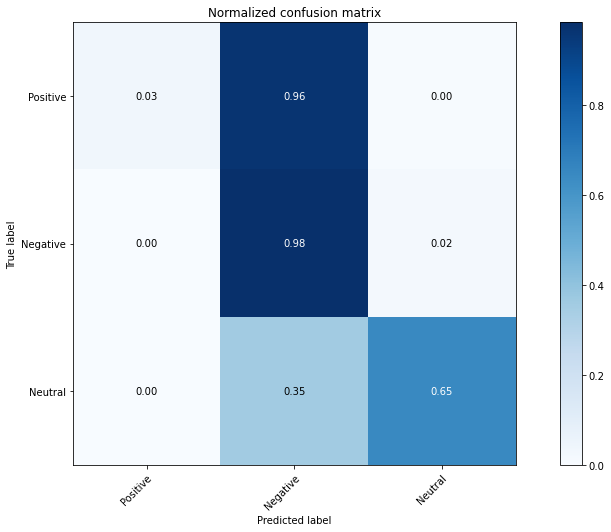

In [52]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
# Save the dataset with only added label (Vader)

df.rename(columns={'Vader Analysis': 'Label'}, inplace=True)
df = df.drop(columns=['POS tagged', 'Lemma', 'Vader Sentiment'])
df.to_csv('sentiment_label.csv', index=False)
df